In [2]:
from torch.utils.data import DataLoader, TensorDataset
from src.embeddings.car_make import CarMakeEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import torch

In [3]:
cme = CarMakeEmbedding(
    "/Users/ignasi/Documents/_03_MDS_/_01_ADSDB_/data/Car_Model_List.csv",
    embedding_size=10,
)
cme.save(
    "/Users/ignasi/Documents/_03_MDS_/_01_ADSDB_/src/embeddings/encoder.pkl",
    "/Users/ignasi/Documents/_03_MDS_/_01_ADSDB_/src/embeddings/embedding.pkl",
)

In [31]:
df = pd.read_csv(
    "/Users/ignasi/Documents/_03_MDS_/_01_ADSDB_/ui/sample_tables/mvc_safety_rating_by_accidents.csv",
    index_col=0,
)
df["make"] = df["vehicle_make"].apply(lambda x: cme.execute(x)[0])
df["age"] = df["vehicle_year"].apply(lambda x: datetime.now().year - x)
df["sex"] = df["person_sex"].apply(lambda x: int(x == "F"))
df = df[["person_age", "sex", "overall_rating", "make", "age"]]
make_df = pd.DataFrame(
    df["make"].tolist(), columns=[f"make_{i}" for i in range(len(df["make"][0]))]
)
df = pd.concat([df.drop(columns=["make"]), make_df], axis=1)
df = df.dropna()
df.head()

,person_age,sex,overall_rating,age,make_0,make_1,make_2,make_3,make_4,make_5,make_6,make_7,make_8,make_9
0,53,1,4.166667,21.0,0.379497,-0.571041,-0.531895,-1.433014,0.831354,-0.560324,-1.735861,0.432421,0.064999,-0.356456
1,53,1,4.000000,21.0,0.379497,-0.571041,-0.531895,-1.433014,0.831354,-0.560324,-1.735861,0.432421,0.064999,-0.356456
2,24,0,4.333333,21.0,0.379497,-0.571041,-0.531895,-1.433014,0.831354,-0.560324,-1.735861,0.432421,0.064999,-0.356456
3,24,0,4.200000,21.0,0.379497,-0.571041,-0.531895,-1.433014,0.831354,-0.560324,-1.735861,0.432421,0.064999,-0.356456
4,24,0,4.166667,21.0,0.379497,-0.571041,-0.531895,-1.433014,0.831354,-0.560324,-1.735861,0.432421,0.064999,-0.356456


In [32]:
scaler = MinMaxScaler()
features = df.to_numpy()
features = scaler.fit_transform(features)

In [33]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU())
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)  # Limit logvar range
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [34]:
def vae_loss(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = nn.MSELoss(reduction="sum")(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [35]:
input_dim = len(df.columns)
hidden_dim = 32
latent_dim = 5
learning_rate = 1e-5
batch_size = 64
num_epochs = 1000

dataset = TensorDataset(torch.tensor(features, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [36]:
loss_history = []
vae.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar, beta=0.1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    loss_history.append(total_loss)

100%|██████████| 1000/1000 [01:03<00:00, 15.78it/s]


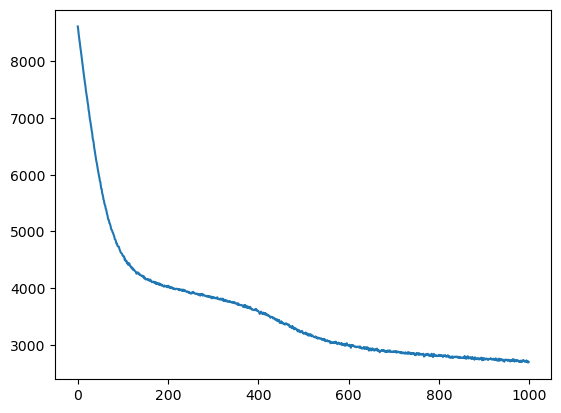

In [37]:
plt.plot(loss_history)

In [41]:
correct = 0
for i in range(len(features)):
    reconstruction = vae(torch.tensor(features[i], dtype=torch.float32))[0]
    rec = cme.reverse_execute(reconstruction.detach().cpu().numpy()[-10:])
    default = cme.reverse_execute(features[i][-10:])
    correct += default == rec

In [43]:
correct, len(features)

(5003, 5788)